### Install Libraries

In [ ]:
!pip install -q tensorflow seaborn scikit-learn matplotlib tqdm pandas

### Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### Check TensorFlow and GPU

In [ ]:
print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Helper functions for plotting and evaluation

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(title+" Accuracy"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(title+" Loss"); plt.legend()
    plt.show()

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()

def plot_roc(y_true_onehot, y_pred_prob, title):
    plt.figure(figsize=(6,5))
    for i in range(y_true_onehot.shape[1]):
        fpr, tpr, _ = roc_curve(y_true_onehot[:,i], y_pred_prob[:,i])
        plt.plot(fpr, tpr, label=f'Class {i}')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"{title} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

def macro_auc(y_true_onehot, y_pred_prob):
    fpr,tpr,roc_auc={},{},{}
    for i in range(y_true_onehot.shape[1]):
        fpr[i],tpr[i],_ = roc_curve(y_true_onehot[:,i], y_pred_prob[:,i])
        roc_auc[i]=auc(fpr[i],tpr[i])
    return np.mean(list(roc_auc.values()))

### Load and preprocess data

In [ ]:
(m_x_train, m_y_train),(m_x_test, m_y_test)=keras.datasets.mnist.load_data()
m_x_all = np.concatenate([m_x_train, m_x_test]).astype('float32')/255.0
m_x_all = np.expand_dims(m_x_all,-1)
m_y_all = np.concatenate([m_y_train, m_y_test])
m_y_all_cat = to_categorical(m_y_all,10)
m_x_all_vgg = tf.image.resize(tf.image.grayscale_to_rgb(tf.convert_to_tensor(m_x_all)),[32,32]).numpy()

# CIFAR-10
(c_x_train,c_y_train),(c_x_test,c_y_test)=keras.datasets.cifar10.load_data()
c_x_all = np.concatenate([c_x_train,c_x_test]).astype('float32')/255.0
c_y_all = np.concatenate([c_y_train,c_y_test]).flatten()
c_y_all_cat = to_categorical(c_y_all,10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


### Model Building Functions

In [ ]:
def build_cnn(input_shape,n_classes):
    model=models.Sequential([
        layers.Conv2D(32,3,activation='relu',padding='same',input_shape=input_shape),
        layers.Conv2D(32,3,activation='relu',padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3,activation='relu',padding='same'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(n_classes,activation='softmax')
    ])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

def build_vgg16(input_shape,n_classes):
    base=VGG16(include_top=False,weights=None,input_shape=input_shape)
    x=layers.Flatten()(base.output)
    x=layers.Dense(256,activation='relu')(x)
    out=layers.Dense(n_classes,activation='softmax')(x)
    model=models.Model(base.input,out)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

def build_alexnet_small(input_shape,n_classes):
    model=models.Sequential([
        layers.Conv2D(64,(3,3),activation='relu',padding='same',input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128,(3,3),activation='relu',padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(256,(3,3),activation='relu',padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(512,activation='relu'),
        layers.Dense(n_classes,activation='softmax')
    ])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

def build_googlenet_small(input_shape,n_classes):
    inp=layers.Input(shape=input_shape)
    x=layers.Conv2D(64,3,activation='relu',padding='same')(inp)
    x=layers.Conv2D(128,3,activation='relu',padding='same')(x)
    x=layers.MaxPooling2D(2)(x)
    x=layers.Conv2D(256,3,activation='relu',padding='same')(x)
    x=layers.MaxPooling2D(2)(x)
    x=layers.Flatten()(x)
    x=layers.Dense(512,activation='relu')(x)
    out=layers.Dense(n_classes,activation='softmax')(x)
    model=models.Model(inp,out)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

def build_rnn(input_shape,n_classes):
    model=models.Sequential([
        layers.Input(shape=(input_shape[0],input_shape[1])),
        layers.LSTM(128),
        layers.Dense(128,activation='relu'),
        layers.Dense(n_classes,activation='softmax')
    ])
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

### Training and Evaluation

In [ ]:
def train_and_eval(model,X_train,y_train,X_test,y_test,y_test_cat,name,dataset,split_ratio):
    hist=model.fit(X_train,y_train,validation_split=0.1,epochs=5,batch_size=128,verbose=2)
    eval_res=model.evaluate(X_test,y_test_cat,verbose=0)
    preds=model.predict(X_test)
    pred_labels=np.argmax(preds,axis=1)
    rocA=macro_auc(y_test_cat,preds)
    report=classification_report(y_test,pred_labels,output_dict=True,zero_division=0)
    acc,prec,rec,f1=eval_res[1],report['weighted avg']['precision'],report['weighted avg']['recall'],report['weighted avg']['f1-score']
    return {"Dataset":dataset,"Model":name,"Split":split_ratio,"Accuracy":acc,"Precision":prec,"Recall":rec,"F1":f1,"AUC":rocA,"History":hist,"Y_true":y_test,"Y_pred":preds}

### initialization of results and splits

In [ ]:
results=[]
splits = [0.6,0.7,0.8]

### MNIST Model Training

In [ ]:
mnist_models=[
    ("CNN", build_cnn((28,28,1),10)),
    ("VGG16", build_vgg16((32,32,3),10)),
    ("AlexNet", build_alexnet_small((32,32,3),10)),
    ("GoogLeNet", build_googlenet_small((32,32,3),10)),
    ("RNN", build_rnn((28,28),10))
]

for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(m_x_all, m_y_all, train_size=split, random_state=42, stratify=m_y_all)
    X_train_cat, X_test_cat = to_categorical(y_train,10), to_categorical(y_test,10)
    X_train_vgg, X_test_vgg = tf.image.resize(tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train)),[32,32]).numpy(), \
                               tf.image.resize(tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test)),[32,32]).numpy()

    for name, model in mnist_models:
        if name in ["VGG16","AlexNet","GoogLeNet"]:
            res=train_and_eval(model,X_train_vgg,X_train_cat,X_test_vgg,y_test,X_test_cat,name,"MNIST",split)
        elif name=="RNN":
            res=train_and_eval(model,X_train[:,:,0],X_train_cat,X_test[:,:,0],y_test,X_test_cat,name,"MNIST",split)
        else:
            res=train_and_eval(model,X_train,X_train_cat,X_test,y_test,X_test_cat,name,"MNIST",split)
        results.append(res)

Epoch 1/5
296/296 - 11s - 36ms/step - accuracy: 0.9240 - loss: 0.2475 - val_accuracy: 0.9676 - val_loss: 0.1058
Epoch 2/5
296/296 - 2s - 7ms/step - accuracy: 0.9811 - loss: 0.0585 - val_accuracy: 0.9836 - val_loss: 0.0533
Epoch 3/5
296/296 - 2s - 7ms/step - accuracy: 0.9880 - loss: 0.0389 - val_accuracy: 0.9876 - val_loss: 0.0394
Epoch 4/5
296/296 - 2s - 7ms/step - accuracy: 0.9914 - loss: 0.0261 - val_accuracy: 0.9852 - val_loss: 0.0460
Epoch 5/5
296/296 - 2s - 7ms/step - accuracy: 0.9924 - loss: 0.0224 - val_accuracy: 0.9862 - val_loss: 0.0468
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Epoch 1/5
296/296 - 46s - 156ms/step - accuracy: 0.2752 - loss: 1.8543 - val_accuracy: 0.7274 - val_loss: 0.7832
Epoch 2/5
296/296 - 22s - 74ms/step - accuracy: 0.9247 - loss: 0.2538 - val_accuracy: 0.9576 - val_loss: 0.1505
Epoch 3/5
296/296 - 22s - 75ms/step - accuracy: 0.9706 - loss: 0.1060 - val_accuracy: 0.9788 - val_loss: 0.0876
Epoch 4/5
296/296 - 22s - 75ms/step - accuracy: 0.9799 - loss: 0.0723 

### CIFAR-10 Model Training

In [ ]:
cifar_models=[
    ("CNN", build_cnn((32,32,3),10)),
    ("VGG16", build_vgg16((32,32,3),10)),
    ("AlexNet", build_alexnet_small((32,32,3),10)),
    ("GoogLeNet", build_googlenet_small((32,32,3),10)),
    ("RNN", build_rnn((32,32*3),10))
]

for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(c_x_all, c_y_all, train_size=split, random_state=42, stratify=c_y_all)
    X_train_cat, X_test_cat = to_categorical(y_train,10), to_categorical(y_test,10)

    for name, model in cifar_models:
        if name=="RNN":
            X_train_rnn = X_train.reshape(-1,32,32*3)
            X_test_rnn = X_test.reshape(-1,32,32*3)
            res=train_and_eval(model,X_train_rnn,X_train_cat,X_test_rnn,y_test,X_test_cat,name,"CIFAR10",split)
        else:
            res=train_and_eval(model,X_train,X_train_cat,X_test,y_test,X_test_cat,name,"CIFAR10",split)
        results.append(res)

Epoch 1/5
254/254 - 9s - 36ms/step - accuracy: 0.4046 - loss: 1.6505 - val_accuracy: 0.4947 - val_loss: 1.4160
Epoch 2/5
254/254 - 2s - 8ms/step - accuracy: 0.5713 - loss: 1.2077 - val_accuracy: 0.6086 - val_loss: 1.1084
Epoch 3/5
254/254 - 2s - 8ms/step - accuracy: 0.6406 - loss: 1.0212 - val_accuracy: 0.6369 - val_loss: 1.0209
Epoch 4/5
254/254 - 2s - 9ms/step - accuracy: 0.6881 - loss: 0.8997 - val_accuracy: 0.6647 - val_loss: 0.9777
Epoch 5/5
254/254 - 2s - 9ms/step - accuracy: 0.7217 - loss: 0.8029 - val_accuracy: 0.6722 - val_loss: 0.9510
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Epoch 1/5
254/254 - 35s - 137ms/step - accuracy: 0.0982 - loss: 2.3116 - val_accuracy: 0.0922 - val_loss: 2.3028
Epoch 2/5
254/254 - 19s - 76ms/step - accuracy: 0.0957 - loss: 2.3028 - val_accuracy: 0.0964 - val_loss: 2.3028
Epoch 3/5
254/254 - 19s - 75ms/step - accuracy: 0.0979 - loss: 2.3027 - val_accuracy: 0.0922 - val_loss: 2.3027
Epoch 4/5
254/254 - 19s - 76ms/step - accuracy: 0.0995 - loss: 2.3027 -

### Final Deep Learning Comparison Table

In [ ]:
df=pd.DataFrame(results)
print("\n=== Final Deep Learning Comparison Table (Multiple Splits) ===")
display(df)
df.to_csv("DeepLearning_Comparison_MultiSplits.csv",index=False)
print("Saved DeepLearning_Comparison_MultiSplits.csv ✅")


=== Final Deep Learning Comparison Table (Multiple Splits) ===


,Dataset,Model,Split,Accuracy,Precision,Recall,F1,AUC,History,Y_true,Y_pred
0,MNIST,CNN,0.6,0.985250,0.985369,0.985250,0.985251,0.999821,<keras.src.callbacks.history.History object at...,"[7, 6, 6, 9, 0, 6, 6, 1, 4, 0, 6, 4, 1, 4, 3, ...","[[4.2072874e-09, 5.7757566e-12, 6.455206e-08, ..."
1,MNIST,VGG16,0.6,0.984500,0.984638,0.984500,0.984516,0.999639,<keras.src.callbacks.history.History object at...,"[7, 6, 6, 9, 0, 6, 6, 1, 4, 0, 6, 4, 1, 4, 3, ...","[[7.4887804e-11, 1.7243433e-08, 5.5111727e-06,..."
2,MNIST,AlexNet,0.6,0.990250,0.990291,0.990250,0.990243,0.999894,<keras.src.callbacks.history.History object at...,"[7, 6, 6, 9, 0, 6, 6, 1, 4, 0, 6, 4, 1, 4, 3, ...","[[1.185604e-10, 7.100689e-11, 3.0996095e-09, 1..."
3,MNIST,GoogLeNet,0.6,0.987786,0.987857,0.987786,0.987780,0.999864,<keras.src.callbacks.history.History object at...,"[7, 6, 6, 9, 0, 6, 6, 1, 4, 0, 6, 4, 1, 4, 3, ...","[[4.4899932e-13, 3.985523e-13, 3.83804e-10, 3...."
4,MNIST,RNN,0.6,0.112536,0.012664,0.112536,0.022767,0.499890,<keras.src.callbacks.history.History object at...,"[7, 6, 6, 9, 0, 6, 6, 1, 4, 0, 6, 4, 1, 4, 3, ...","[[0.100687034, 0.11131266, 0.10096758, 0.10197..."
5,MNIST,CNN,0.7,0.988762,0.988840,0.988762,0.988768,0.999878,<keras.src.callbacks.history.History object at...,"[7, 8, 2, 2, 3, 9, 2, 1, 6, 5, 9, 5, 8, 9, 8, ...","[[1.8884299e-15, 2.721718e-13, 5.23878e-13, 2...."
6,MNIST,VGG16,0.7,0.989524,0.989542,0.989524,0.989523,0.999731,<keras.src.callbacks.history.History object at...,"[7, 8, 2, 2, 3, 9, 2, 1, 6, 5, 9, 5, 8, 9, 8, ...","[[6.963394e-21, 1.6274407e-12, 2.5858004e-15, ..."
7,MNIST,AlexNet,0.7,0.989238,0.989290,0.989238,0.989231,0.999889,<keras.src.callbacks.history.History object at...,"[7, 8, 2, 2, 3, 9, 2, 1, 6, 5, 9, 5, 8, 9, 8, ...","[[6.218667e-17, 4.200693e-11, 1.898188e-11, 1...."
8,MNIST,GoogLeNet,0.7,0.988952,0.988991,0.988952,0.988956,0.999908,<keras.src.callbacks.history.History object at...,"[7, 8, 2, 2, 3, 9, 2, 1, 6, 5, 9, 5, 8, 9, 8, ...","[[9.410928e-21, 4.7620626e-14, 4.6781198e-15, ..."
9,MNIST,RNN,0.7,0.112524,0.012662,0.112524,0.022762,0.499986,<keras.src.callbacks.history.History object at...,"[7, 8, 2, 2, 3, 9, 2, 1, 6, 5, 9, 5, 8, 9, 8, ...","[[0.09892479, 0.109901, 0.10064943, 0.10199530..."


Saved DeepLearning_Comparison_MultiSplits.csv ✅


### Select best cases

In [ ]:
best_cases = df.loc[df.groupby(['Dataset','Model'])['Accuracy'].idxmax()]

### Plot best cases

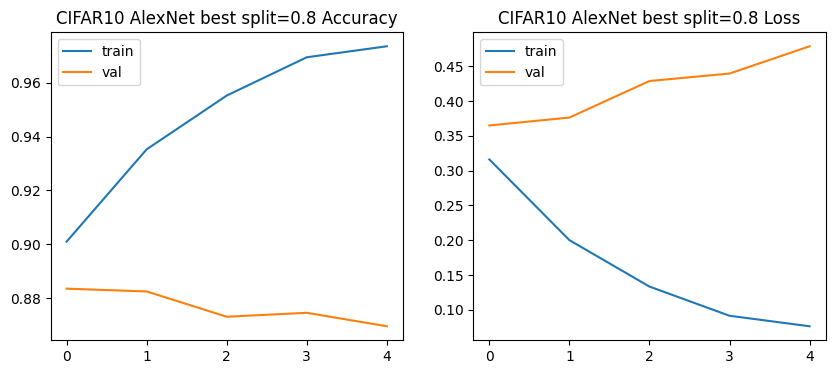

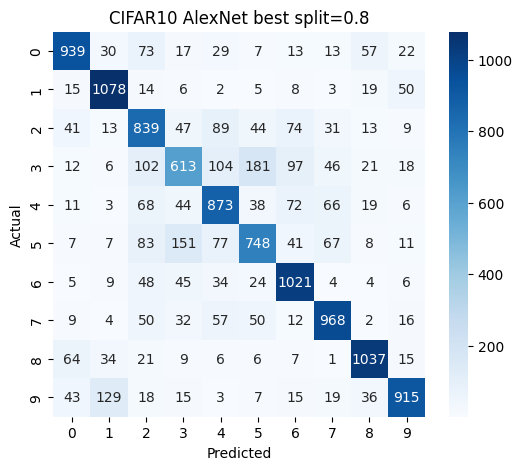

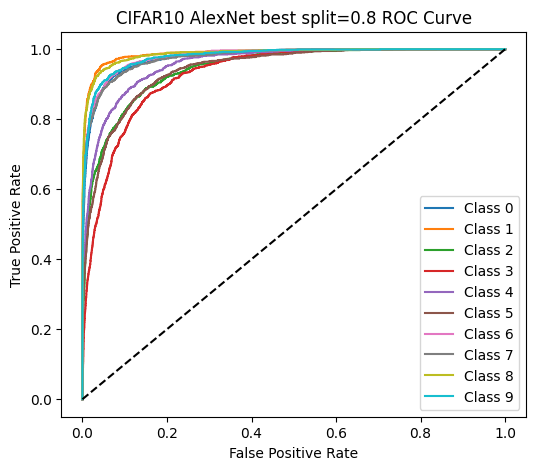

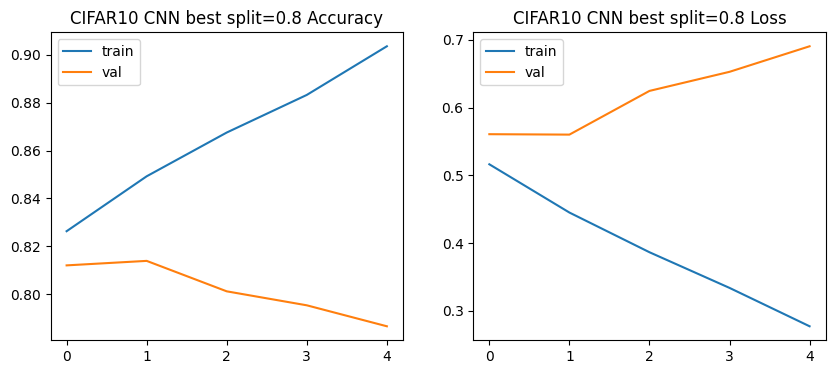

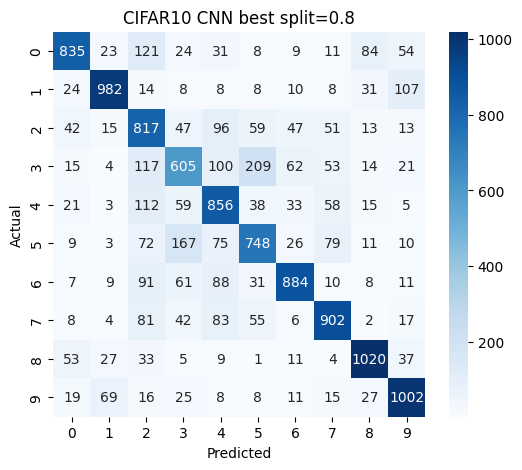

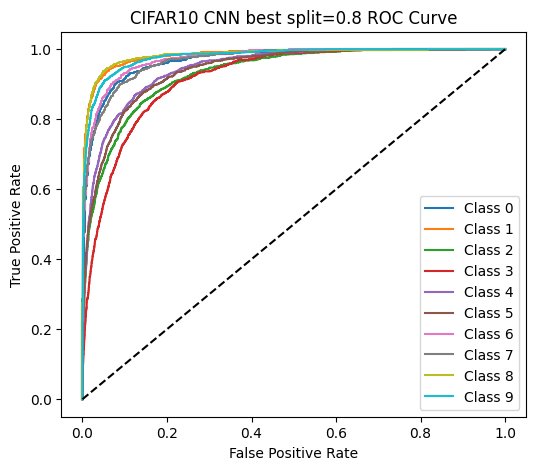

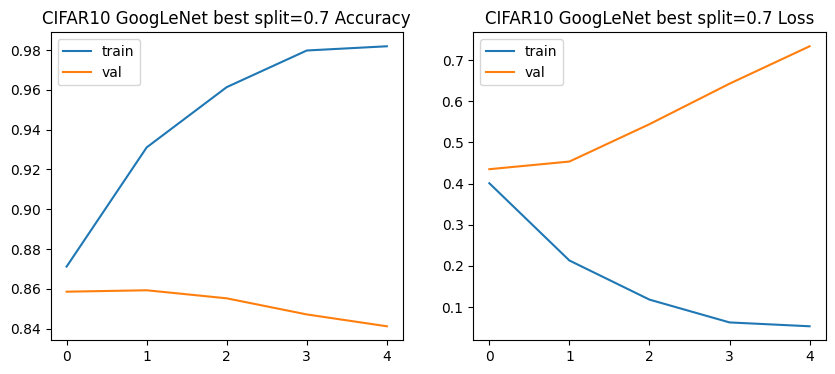

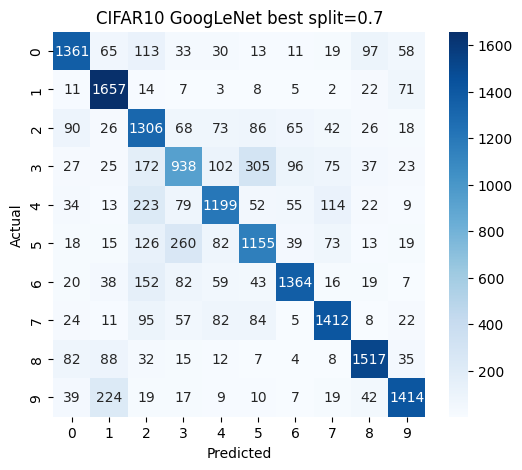

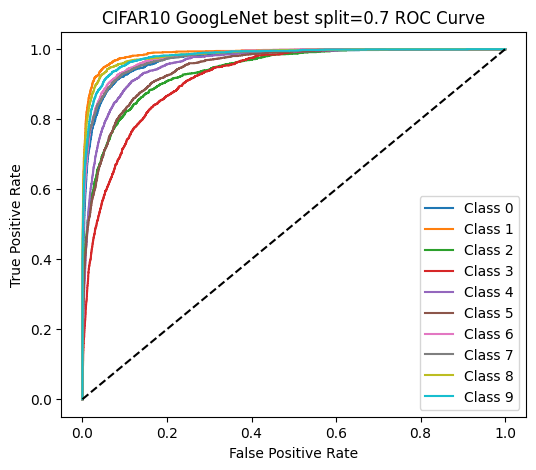

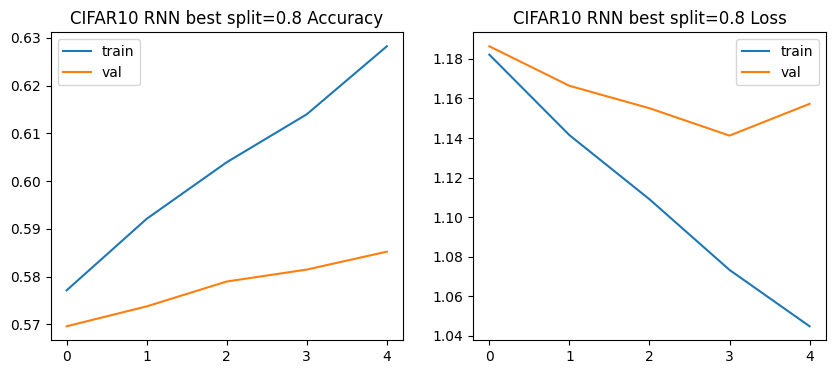

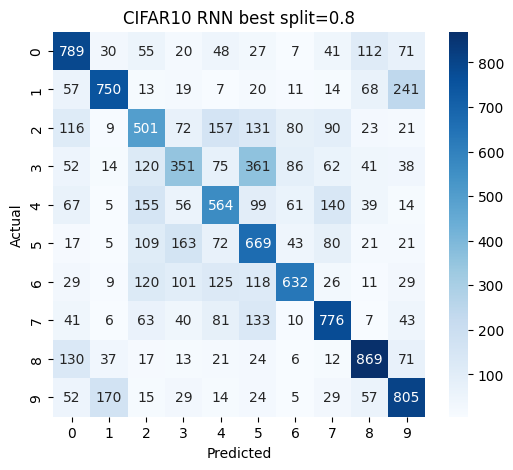

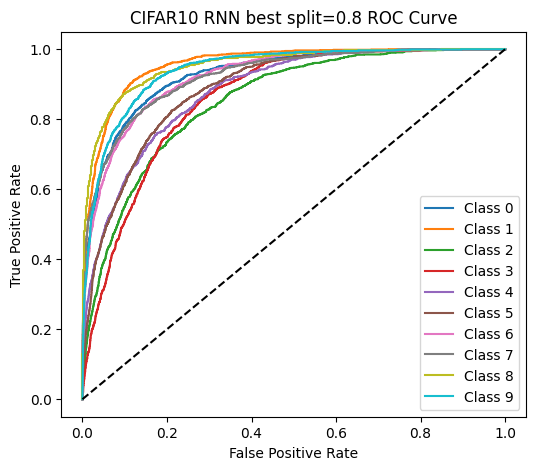

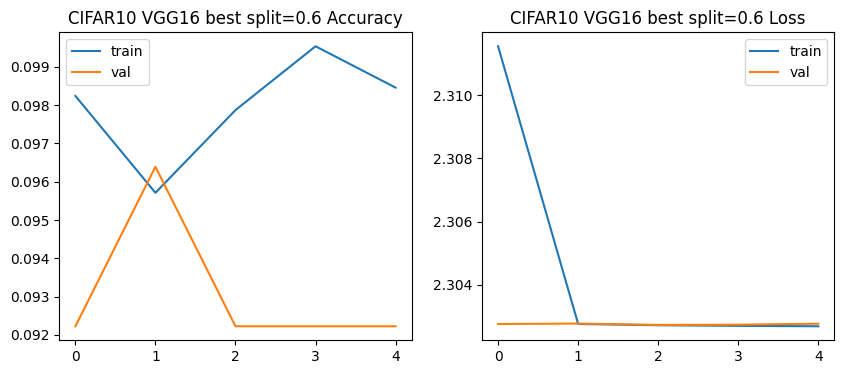

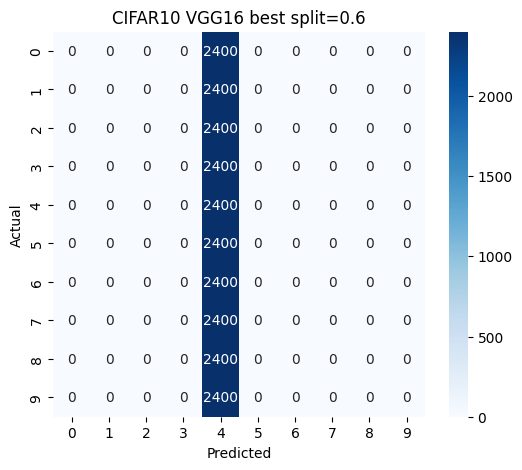

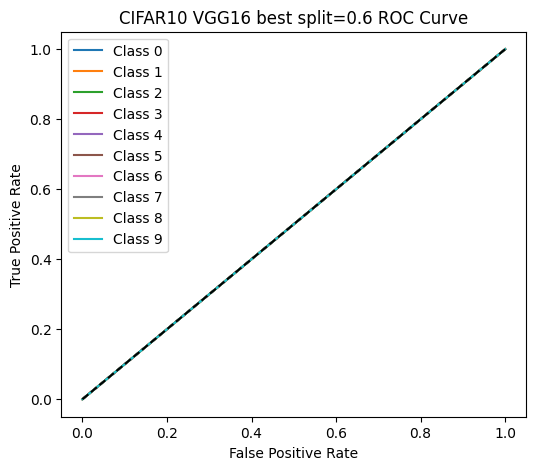

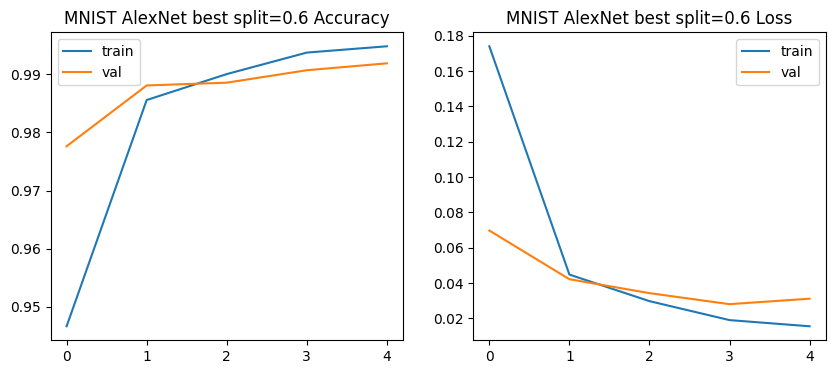

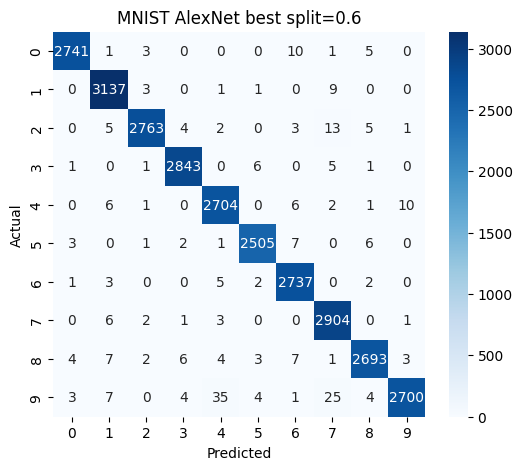

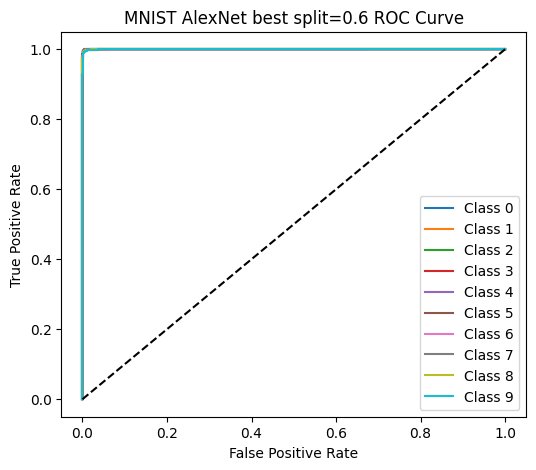

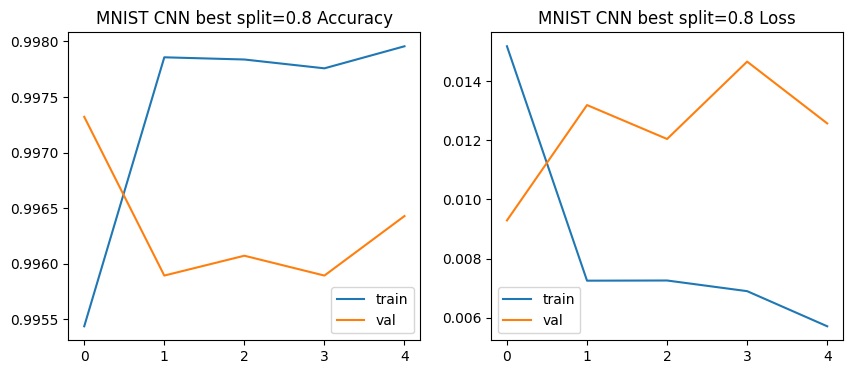

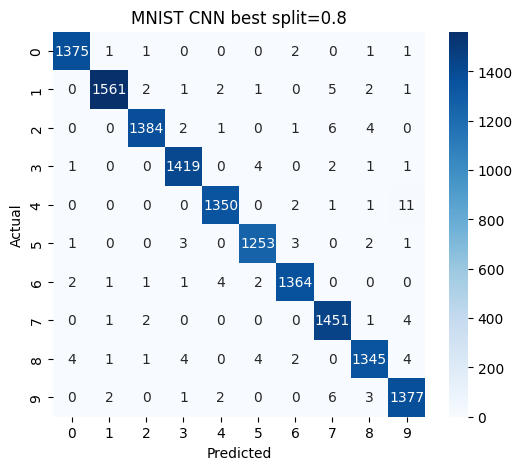

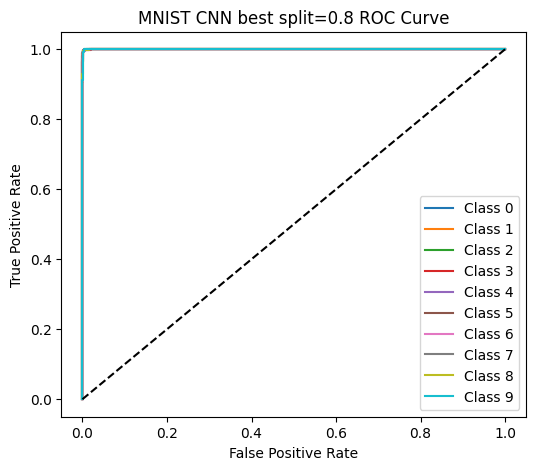

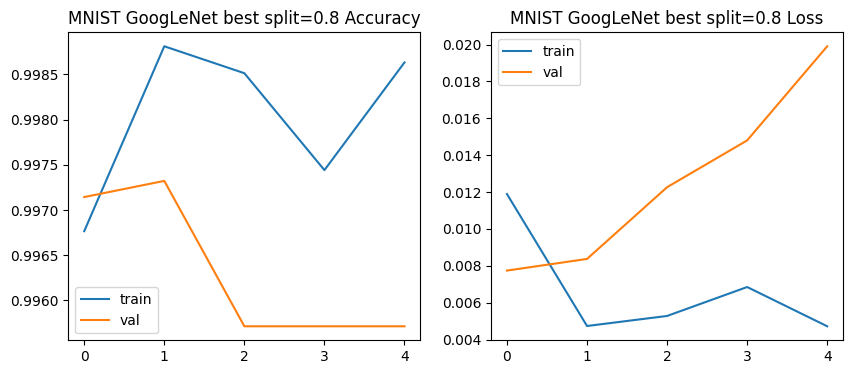

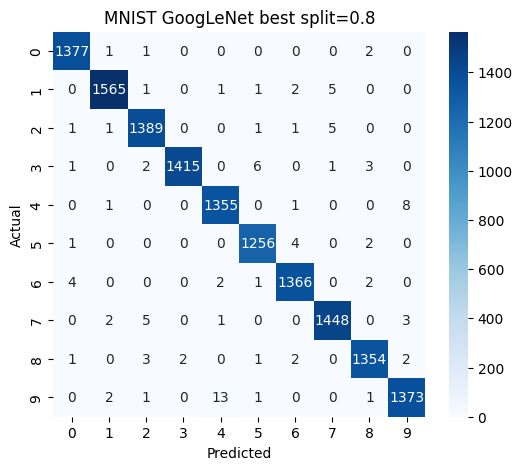

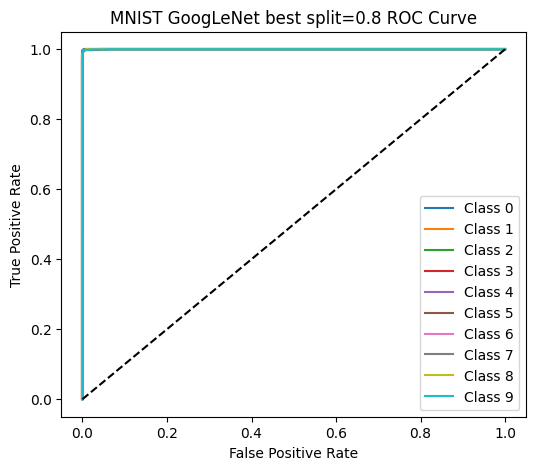

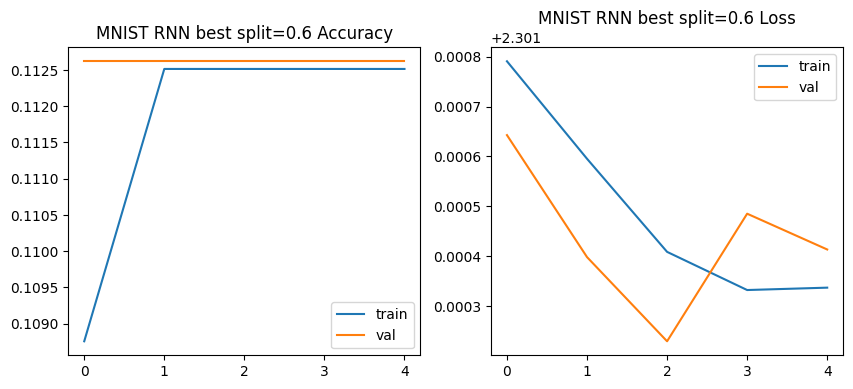

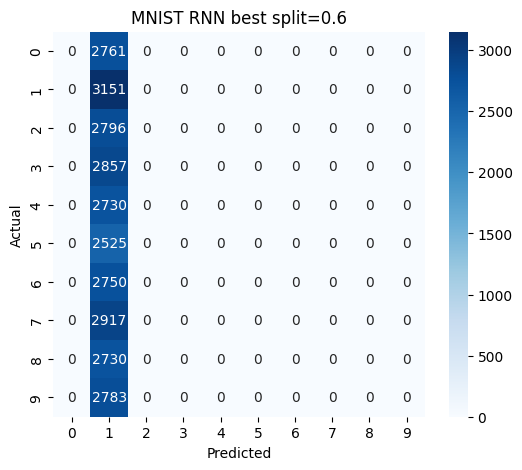

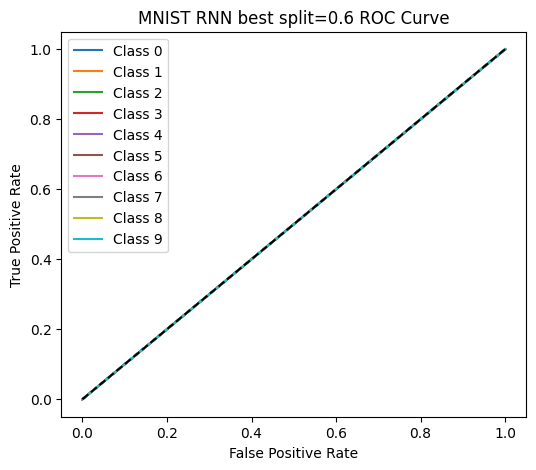

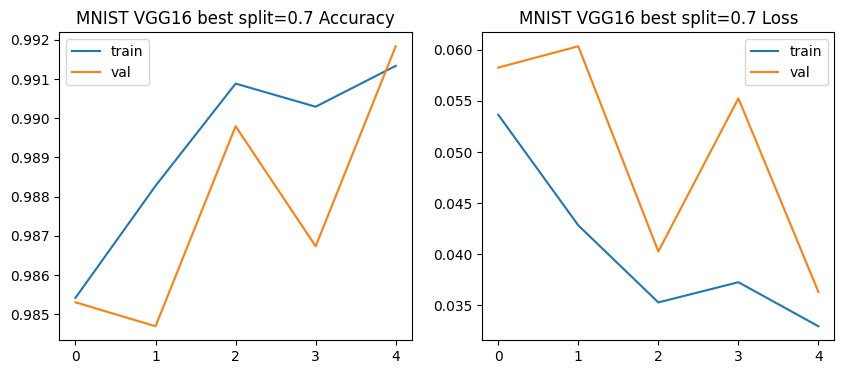

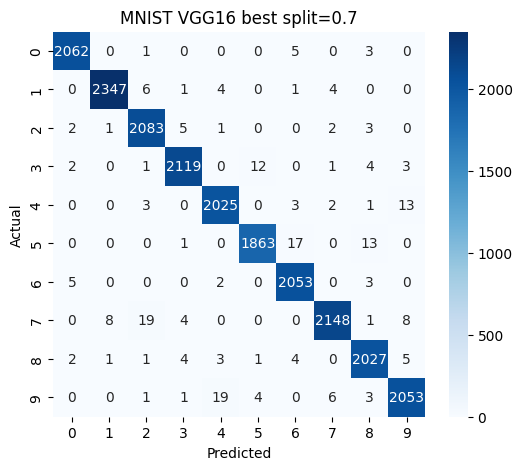

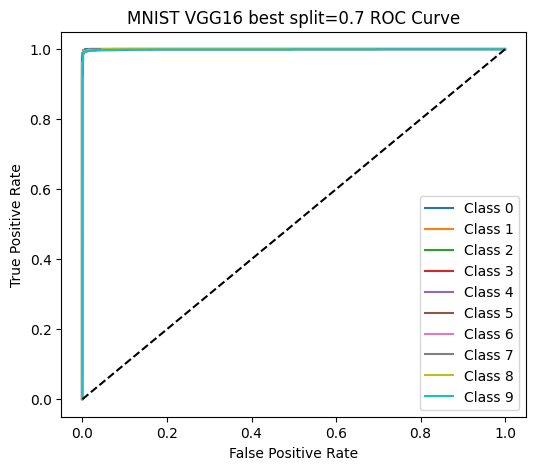

In [ ]:
for idx, row in best_cases.iterrows():
    hist = row['History']
    y_true = row['Y_true']
    y_pred = row['Y_pred']
    plot_history(hist,f"{row['Dataset']} {row['Model']} best split={row['Split']}")
    pred_labels = np.argmax(y_pred,axis=1)
    plot_cm(y_true,pred_labels,f"{row['Dataset']} {row['Model']} best split={row['Split']}")
    plot_roc(to_categorical(y_true,10), y_pred, f"{row['Dataset']} {row['Model']} best split={row['Split']}")

### Save best case comparison

In [ ]:
best_cases.drop(columns=['History','Y_true','Y_pred'], inplace=True)
best_cases.to_csv("DeepLearning_BestCase_Comparison.csv",index=False)
print("Saved DeepLearning_BestCase_Comparison.csv ✅")
display(best_cases)

Saved DeepLearning_BestCase_Comparison.csv ✅


,Dataset,Model,Split,Accuracy,Precision,Recall,F1,AUC
27,CIFAR10,AlexNet,0.8,0.752583,0.751822,0.752583,0.750502,0.966749
25,CIFAR10,CNN,0.8,0.720917,0.725810,0.720917,0.721476,0.959645
23,CIFAR10,GoogLeNet,0.7,0.740167,0.743278,0.740167,0.739463,0.964107
29,CIFAR10,RNN,0.8,0.558833,0.561887,0.558833,0.556628,0.911076
16,CIFAR10,VGG16,0.6,0.100000,0.010000,0.100000,0.018182,0.500000
2,MNIST,AlexNet,0.6,0.990250,0.990291,0.990250,0.990243,0.999894
10,MNIST,CNN,0.8,0.991357,0.991371,0.991357,0.991359,0.999947
13,MNIST,GoogLeNet,0.8,0.992714,0.992722,0.992714,0.992715,0.999920
4,MNIST,RNN,0.6,0.112536,0.012664,0.112536,0.022767,0.499890
6,MNIST,VGG16,0.7,0.989524,0.989542,0.989524,0.989523,0.999731
